## Pregunta 3:
### ¿La distribución del nivel de escolaridad en víctimas de violencia intrafamiliar difiere significativamente de la distribución observada en personas que se divorcian?

IMPORTACIÓN DE LIBRERÍAS

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random
from scipy import stats
import seaborn as sns
from scipy.stats import chi2_contingency

CARGA DE ARCHIVOS

In [60]:
df_div = pd.read_csv('../files/divorcios_limpio1.csv', encoding="latin1")
df_viol = pd.read_csv('../files/violencia_intrafamiliar_limpio1.csv', encoding="latin1")

/var/folders/dc/_dt3fhrs48n2b_4mmncch3440000gp/T/ipykernel_30209/3719126337.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_div = pd.read_csv('../files/divorcios_limpio1.csv', encoding="latin1")
/var/folders/dc/_dt3fhrs48n2b_4mmncch3440000gp/T/ipykernel_30209/3719126337.py:2: DtypeWarning: Columns (1,3,4,5,7,8,9,11,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_viol = pd.read_csv('../files/violencia_intrafamiliar_limpio1.csv', encoding="latin1")


DEFINICIÓN DE QUE GRUPO SUFRE MÁS VIOLENCIA PARA HACER LA COMPARACIÓN

In [61]:
df_validos = df_viol[df_viol["VIC_SEXO"].notna()]

conteo = df_validos["VIC_SEXO"].value_counts()

porcentaje_sexo = df_validos["VIC_SEXO"].value_counts(normalize=True) * 100

total_mujeres = (
    conteo.get("Mujeres", 0) +
    conteo.get("2", 0) +
    conteo.get(2, 0)
)

total_hombres = (
    conteo.get("Hombres", 0) +
    conteo.get("1", 0) +
    conteo.get(1, 0)
)

total = total_hombres + total_mujeres

porcentaje_hombre = total_hombres / total * 100
porcentaje_mujer = total_mujeres / total * 100

tabla_frecuencias = pd.DataFrame({
    "Sexo": ["Mujeres", "Hombres"],
    "Frecuencia": [total_mujeres, total_hombres]
})

tabla_frecuencias["Frecuencia relativa"] = (
    tabla_frecuencias["Frecuencia"] / tabla_frecuencias["Frecuencia"].sum()
)

tabla_frecuencias["Porcentaje (%)"] = (
    tabla_frecuencias["Frecuencia relativa"] * 100
)

tabla_frecuencias

,Sexo,Frecuencia,Frecuencia relativa,Porcentaje (%)
0,Mujeres,92176,0.875582,87.558182
1,Hombres,13098,0.124418,12.441818


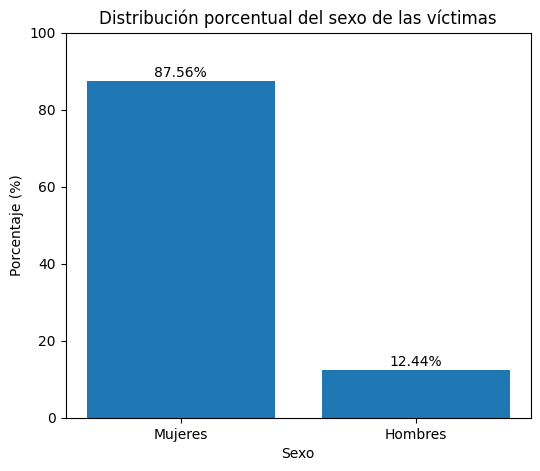

In [62]:
plt.figure(figsize=(6,5))

plt.bar(
    ["Mujeres", "Hombres"],
    [porcentaje_mujer, porcentaje_hombre]
)

plt.title("Distribución porcentual del sexo de las víctimas")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Sexo")
plt.ylim(0, 100)

# Mostrar valores encima de las barras
plt.text(0, porcentaje_mujer + 1, f"{porcentaje_mujer:.2f}%", ha='center')
plt.text(1, porcentaje_hombre + 1, f"{porcentaje_hombre:.2f}%", ha='center')

plt.show()


ASIGNACIÓN DE CLASES

In [63]:
#se decidio solamente comparar nivel bajo y medio porque en escolaridad de los divorcios no hay universitario
def clasificar_escolaridad(valor):
    if pd.isna(valor):
        return pd.NA

    if "PRIMARIA" in valor or "PREPRIMARIA" in valor or "NINGUNA" in valor:
        return "BAJA"
    
    if "BSICO" in valor or "BASICO" in valor or "DIVERSIFICADO" in valor or "UNIVERSITARIO" in valor:
        return "MEDIA+"
    
    return pd.NA

In [64]:
df_div["ESCOLARIDAD_MUJER_NOMBRE"] = df_div["ESCOLARIDAD_MUJER_NOMBRE"].str.upper()

df_div["ESC_GRUPO_MUJ"] = df_div["ESCOLARIDAD_MUJER_NOMBRE"].apply(clasificar_escolaridad)

In [65]:

df_viol["ESC_GRUPO"] = df_viol["VIC_ESCOLARIDAD"].apply(clasificar_escolaridad)

In [66]:
viol = df_viol["ESC_GRUPO"].value_counts()
muj_div = df_div["ESC_GRUPO_MUJ"].value_counts()

tabla_comp_muj = pd.DataFrame({
    "Violencia": viol,
    "Divorcio_Mujeres": muj_div
}).fillna(0)

print(tabla_comp_muj)

        Violencia  Divorcio_Mujeres
BAJA        91910             20216
MEDIA+      23729             14084


CHI-CUADRADO

In [67]:
chi2, p, dof, expected = chi2_contingency(tabla_comp_muj)

print("Chi:", chi2)
print("p:", p)

Chi: 5917.561973803733
p: 0.0


V DE CRAMER

In [68]:
n = tabla_comp_muj.values.sum()
k = min(tabla_comp_muj.shape)

cramer_v = np.sqrt(chi2 / (n * (k - 1)))

print("Cramér V:", cramer_v)

Cramér V: 0.1986616793787502


In [69]:
tabla_comp_muj_pct = tabla_comp_muj / tabla_comp_muj.sum() * 100
print(tabla_comp_muj_pct)

        Violencia  Divorcio_Mujeres
BAJA    79.480106         58.938776
MEDIA+  20.519894         41.061224


<Axes: >

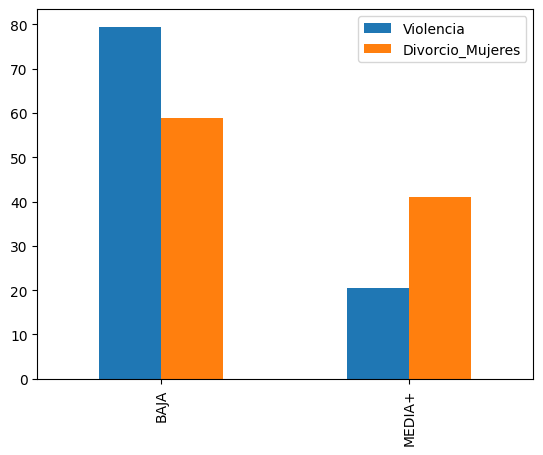

In [71]:
tabla_comp_muj_pct[["Violencia", "Divorcio_Mujeres"]].plot(kind="bar")

RAZÓN DE PROPORCIONES

In [70]:
tabla_comp_muj_pct["Razón"] = tabla_comp_muj_pct["Violencia"] / tabla_comp_muj_pct["Divorcio_Mujeres"]
print(tabla_comp_muj_pct)

        Violencia  Divorcio_Mujeres     Razón
BAJA    79.480106         58.938776  1.348520
MEDIA+  20.519894         41.061224  0.499739


<Axes: >

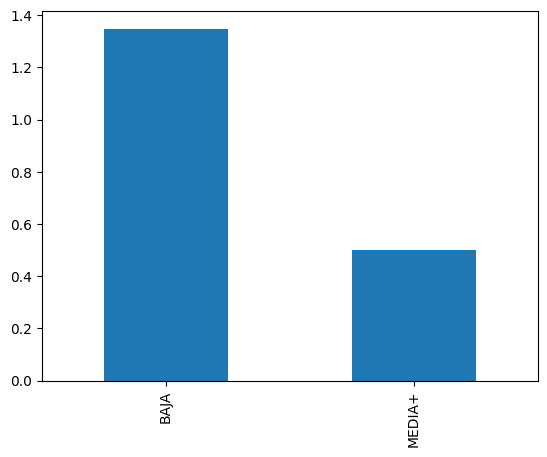

In [73]:
tabla_comp_muj_pct["Razón"].plot(kind="bar")